In [1]:
import openeo
import logging
import os
from pathlib import Path
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

In [2]:
logging.basicConfig(level=logging.INFO)

In [3]:
backend = "https://openeo.vito.be/openeo/0.4.2"

conn = openeo.connect(backend)

In [4]:
conn.list_collection_ids()

['BIOPAR_FAPAR_V1_GLOBAL',
 'CGLS_FAPAR_V2_GLOBAL',
 'CGLS_LAI_V2_GLOBAL',
 'CGLS_LAI300_V1_GLOBAL',
 'CGLS_NDVI300_V1_GLOBAL',
 'CGLS_BA300_V1_GLOBAL',
 'S1_GRD_SIGMA0_ASCENDING',
 'S1_GRD_SIGMA0_DESCENDING',
 'CGS_SENTINEL2_RADIOMETRY_V102_001',
 'S2_FAPAR_V102_WEBMERCATOR2',
 'SENTINEL2_FCOVER_TERRASCOPE',
 'SENTINEL2_NDVI_TERRASCOPE',
 'SENTINEL2_LAI_TERRASCOPE',
 'PROBAV_L3_S10_TOC_NDVI_333M',
 'S2_FAPAR_SCENECLASSIFICATION_V102_PYRAMID',
 'S2_NDVI_S3',
 'CGS_SENTINEL2_RADIOMETRY_V102_FILE',
 'SENTINEL1_GAMMA0_SENTINELHUB',
 'SENTINEL2_L1C_SENTINELHUB',
 'SENTINEL2_L2A_SENTINELHUB',
 'LANDSAT8_L1C_SENTINELHUB',
 'S2_RADIOMETRY_S3_JP2']

In [5]:
udf = """

print(type(data))

raise RuntimeError('failure!')

"""

In [6]:
product = "CGS_SENTINEL2_RADIOMETRY_V102_001"

cube = (
    conn
    .load_collection(product)
    .filter_temporal("2019-10-01", "2019-10-20")
    .filter_bbox(west=5.1, south=51.1, east=5.11, north=51.11, crs="EPSG:4326")
    .apply_dimension(udf, runtime="Python")
)

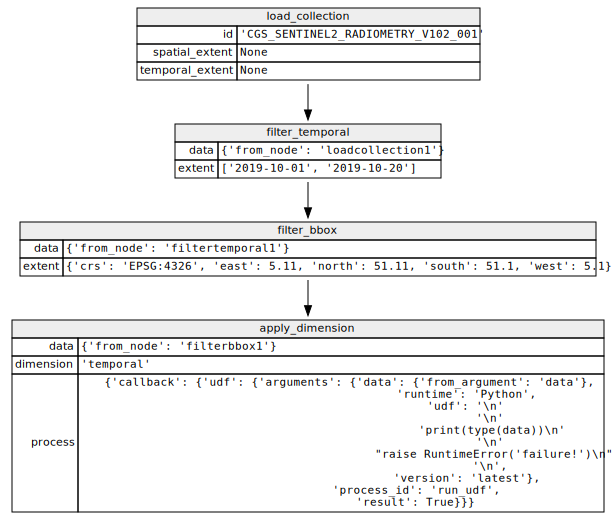

In [7]:
cube.to_graphviz()

In [8]:
%%time
cube.download("hackathon-udf-example-test01.tiff", format="GTIFF")

OpenEoApiError: [500] unknown: Traceback (most recent call last):
  File "/data1/hadoop/yarn/local/usercache/mep_tsviewer/appcache/application_1571907780705_25141/container_e4803_1571907780705_25141_01_000004/pyspark.zip/pyspark/worker.py", line 253, in main
    process()
  File "/data1/hadoop/yarn/local/usercache/mep_tsviewer/appcache/application_1571907780705_25141/container_e4803_1571907780705_25141_01_000004/pyspark.zip/pyspark/worker.py", line 248, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/data1/hadoop/yarn/local/usercache/mep_tsviewer/appcache/application_1571907780705_25141/container_e4803_1571907780705_25141_01_000004/pyspark.zip/pyspark/serializers.py", line 140, in dump_stream
    for obj in iterator:
  File "/data1/hadoop/yarn/local/usercache/mep_tsviewer/appcache/application_1571907780705_25141/container_e4803_1571907780705_25141_01_000004/pyspark.zip/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "/data1/hadoop/yarn/local/usercache/mep_tsviewer/appcache/application_1571907780705_25141/container_e4803_1571907780705_25141_01_000001/venv/lib64/python3.6/site-packages/openeogeotrellis/GeotrellisImageCollection.py", line 229, in tilefunction
  File "<string>", line 5, in <module>
RuntimeError: failure!


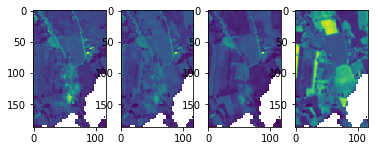

In [9]:
with rasterio.open("hackathon-udf-example-test01.tiff") as dataset:
    fig, axes = plt.subplots(ncols=len(dataset.indexes))
    for i, ax in zip(dataset.indexes, axes):
        ax.imshow(dataset.read(i, masked=True))

In [15]:
from openeo_udf.api.base import UdfData, RasterCollectionTile, SpatialExtent
import numpy as np


cube = [
    RasterCollectionTile(
        id="Band1",
        extent=SpatialExtent(bottom=50, top=55, left=3, right=4),
        data=np.zeros((3, 30, 40))
    ),
    RasterCollectionTile(
        id="Band2",
        extent=SpatialExtent(bottom=50, top=55, left=3, right=4),
        data=np.ones((3, 30, 40))
    ),
]

cube


In [16]:
data = UdfData({"EPSG":900913}, cube)

data

In [20]:
udf = """
print("Hello UDF!")
print(type(data))
"""

In [21]:
exec(udf, {"data": data})

Hello UDF!
<class 'openeo_udf.api.base.UdfData'>
